In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

c:\Users\itsab\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyper parameters

In [3]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # This is the normalization of each dimensions of the input
                                                              # First tuple is the mean of each dimension, second tuple is the std of each dimension

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False) 

100%|██████████| 170498071/170498071 [24:28<00:00, 116082.43it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Display an image

In [20]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize as normalization is done by new_img = ( old_img - mean ) / std 
                        # here 2 is multiplied becoz it is reciprocal of 1/2 ie 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

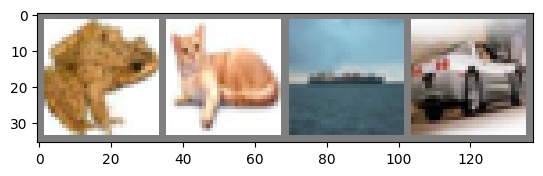

 frog   cat  ship automobile
torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([6, 3, 8, 1])


In [21]:
dataloader_iter = iter(train_loader)

images, labels = next(dataloader_iter)

# print images 

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.shape)
print(labels.shape)
print(labels)

### Showing the dimension change in each layers

Just a sample layers used

In [26]:
def dim_after_conv(input_dim, kernel_dim, padding, stride):
    dim = (input_dim - kernel_dim + 2*padding) / stride + 1
    return dim

### Class for convolution neural network

Sample of dimension change after each layers

In [39]:
conv1 = nn.Conv2d(3, 6, 5) # 3 input channels(RGB image), 6 output channels, 5x5 kernel
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6, 16, 5) # 6 input channels becoz it was the output channel of previous conv layer

print(f"Orginal image batch ( contains 4 images in each batch ) : {images.shape}\n")

x = conv1(images)
print(f"The dimension from the function : {dim_after_conv(input_dim=images.shape[2], kernel_dim= 5, padding= 0, stride=1)}")
print(f"After conv1 : {x.shape}\n")

x = pool(x)
print("When max pooling the dimension is reduced kernel_size times, here it is 2 so halved")
print(f"After pool : {x.shape}\n")

print(f"The dimension from the function : {dim_after_conv(input_dim=images.shape[2], kernel_dim= 5, padding= 0, stride=1)}")
x = conv2(x)
print(f"After conv2 : {x.shape}\n")

x = pool(x)
print("When max pooling the dimension is reduced kernel_size times, here it is 2 so halved")
print(f"After pool : {x.shape}\n")


Orginal image batch ( contains 4 images in each batch ) : torch.Size([4, 3, 32, 32])

The dimension from the function : 28.0
After conv1 : torch.Size([4, 6, 28, 28])

When max pooling the dimension is reduced kernel_size times, here it is 2 so halved
After pool : torch.Size([4, 6, 14, 14])

The dimension from the function : 28.0
After conv2 : torch.Size([4, 16, 10, 10])

When max pooling the dimension is reduced kernel_size times, here it is 2 so halved
After pool : torch.Size([4, 16, 5, 5])



The network

In [43]:
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input dimensions is 3 as it is RGB image , 6 output channels is given by us, 5 is the kernel size 5x5
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5) # input dimensions is 6 as it is the output of previous conv layer, 16 output channels is given by us, 5 is the kernel size 5x5
        
        self.fc1 = nn.Linear((16 * 5 * 5), 120) # The 16 * 5 * 5 is the output of the last conv layer after pooling with 2x2 filter, 
                                                # so it is the input to the fully connected layer so it is flattened
                                                # 120 here can be changed 
                                                
        self.fc2 = nn.Linear(120, 84) # The 84 dimensions can be changed 
        
        self.fc3 = nn.Linear(84, 10) # The 10 comes as there are 10 classes in the CIFAR10 dataset

    def forward(self, x):
        # 1st conv and pooling 
        afterConv1 = self.conv1(x)
        x = self.pool(F.relu(afterConv1))  # -> n, 6, 14, 14
        
        # 2nd conv and pooling
        afterConv2 = self.conv2(x)
        x = self.pool(F.relu(afterConv2))  # -> n, 16, 5, 5
        
        # Flattening
        x = x.view(-1, 16 * 5 * 5)  # -> n, 400
        
        afterFc1 = self.fc1(x)
        x = F.relu(afterFc1)  # -> n, 120
        
        afterFc2 = self.fc2(x)
        x = F.relu(afterFc2)  # -> n, 84
        
        x = self.fc3(x)  # -> n, 10
        
        return x


In [44]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [45]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
    

Epoch [1/5], Step [2000/12500], Loss: 2.3413
Epoch [1/5], Step [4000/12500], Loss: 2.3284
Epoch [1/5], Step [6000/12500], Loss: 2.2935
Epoch [1/5], Step [8000/12500], Loss: 2.3101
Epoch [1/5], Step [10000/12500], Loss: 2.2340
Epoch [1/5], Step [12000/12500], Loss: 2.3416
Epoch [2/5], Step [2000/12500], Loss: 2.3513
Epoch [2/5], Step [4000/12500], Loss: 1.9827
Epoch [2/5], Step [6000/12500], Loss: 1.8122
Epoch [2/5], Step [8000/12500], Loss: 1.3245
Epoch [2/5], Step [10000/12500], Loss: 1.5886
Epoch [2/5], Step [12000/12500], Loss: 2.0063
Epoch [3/5], Step [2000/12500], Loss: 1.5455
Epoch [3/5], Step [4000/12500], Loss: 1.4023
Epoch [3/5], Step [6000/12500], Loss: 2.7967
Epoch [3/5], Step [8000/12500], Loss: 1.6633
Epoch [3/5], Step [10000/12500], Loss: 2.5286
Epoch [3/5], Step [12000/12500], Loss: 2.1219
Epoch [4/5], Step [2000/12500], Loss: 1.3825
Epoch [4/5], Step [4000/12500], Loss: 1.0685
Epoch [4/5], Step [6000/12500], Loss: 1.8445
Epoch [4/5], Step [8000/12500], Loss: 0.5716
Epoc

In [46]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 49.94 %
Accuracy of airplane: 59.1 %
Accuracy of automobile: 74.0 %
Accuracy of bird: 28.7 %
Accuracy of cat: 37.6 %
Accuracy of deer: 43.0 %
Accuracy of dog: 37.7 %
Accuracy of frog: 58.0 %
Accuracy of horse: 60.2 %
Accuracy of ship: 52.6 %
Accuracy of truck: 48.5 %
